In [6]:
import pandas as pd# Load only building1, meter1
df = pd.read_hdf('redd.h5', key='building1/elec/meter1')

store = pd.HDFStore('redd.h5')
print(store.keys())  # Check all top-level datasets/groups
store.close()


['/building6/elec/meter1', '/building6/elec/meter10', '/building6/elec/meter11', '/building6/elec/meter12', '/building6/elec/meter13', '/building6/elec/meter14', '/building6/elec/meter15', '/building6/elec/meter16', '/building6/elec/meter17', '/building6/elec/meter2', '/building6/elec/meter3', '/building6/elec/meter4', '/building6/elec/meter5', '/building6/elec/meter6', '/building6/elec/meter7', '/building6/elec/meter8', '/building6/elec/meter9', '/building6/elec/cache/meter8/good_sections', '/building6/elec/cache/meter8/total_energy', '/building5/elec/meter1', '/building5/elec/meter10', '/building5/elec/meter11', '/building5/elec/meter12', '/building5/elec/meter13', '/building5/elec/meter14', '/building5/elec/meter15', '/building5/elec/meter16', '/building5/elec/meter17', '/building5/elec/meter18', '/building5/elec/meter19', '/building5/elec/meter2', '/building5/elec/meter20', '/building5/elec/meter21', '/building5/elec/meter22', '/building5/elec/meter23', '/building5/elec/meter24', '

In [7]:
# Load only building1, meter1
df = pd.read_hdf('redd.h5', key='building1/elec/meter1')
df.head()

physical_quantity,power
type,apparent
2011-04-18 09:22:09-04:00,224.190002
2011-04-18 09:22:10-04:00,225.570007
2011-04-18 09:22:11-04:00,226.089996
2011-04-18 09:22:12-04:00,222.740005
2011-04-18 09:22:13-04:00,222.199997


In [8]:
# Replace missing values with forward fill, then back fill
df = df.fillna(method='ffill').fillna(method='bfill')

print("Any NaNs left?", df.isna().sum().sum())


Any NaNs left? 0


C:\Users\manoj\AppData\Local\Temp\ipykernel_7532\3111836062.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


In [9]:
# Define target column
target_col = "power"   # change if your dataset has another name

# Drop columns not useful
drop_cols = ['time'] if 'time' in df.columns else []
feature_cols = [col for col in df.columns if col not in drop_cols + [target_col]]

X = df[feature_cols]
y = df[target_col]

print("Features used:", feature_cols)
print("Target:", target_col)


Features used: [('power', 'apparent')]
Target: power


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(len(X_train), len(X_test))


1249328 312332


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Random Forest with strong settings
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,      # shallower trees to avoid memorization
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Predictions
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Metrics
train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.3f}, R2: {train_r2:.6f}")
print(f"Test RMSE: {test_rmse:.3f}, R2: {test_r2:.6f}")


C:\Users\manoj\anaconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train RMSE: 0.434, R2: 0.999999
Test RMSE: 1.995, R2: 0.999978


In [15]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(rf, X, y, cv=tscv, scoring="r2", n_jobs=-1)

print("Cross-validated R2 scores:", scores)
print("Mean R2:", scores.mean())


Cross-validated R2 scores: [0.99568263 0.99999813 0.99682307 0.999939   0.99997749]
Mean R2: 0.9984840622755158


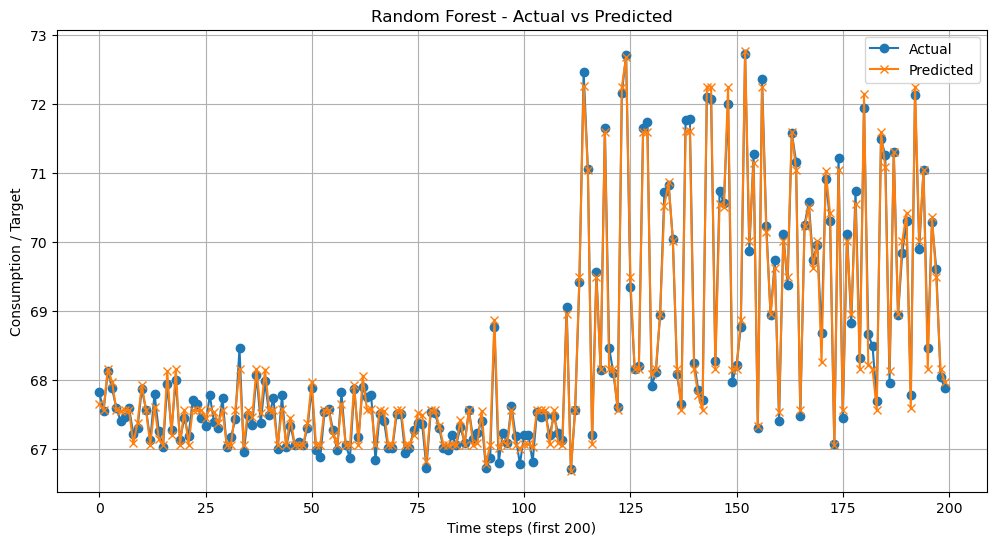

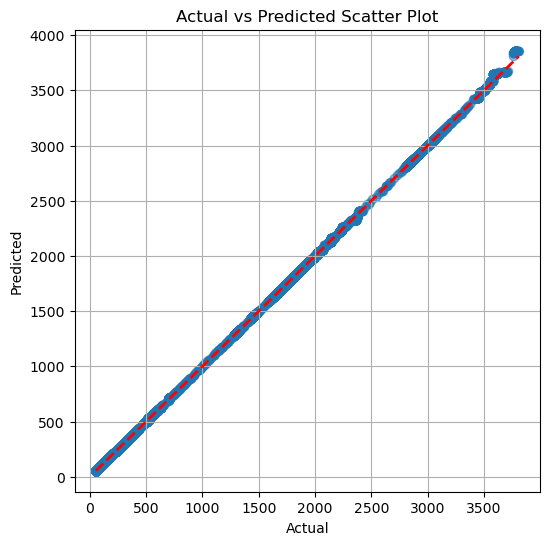

In [16]:
import matplotlib.pyplot as plt

# Plot Actual vs Predicted
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:200], label="Actual", marker='o')
plt.plot(y_test_pred[:200], label="Predicted", marker='x')
plt.xlabel("Time steps (first 200)")
plt.ylabel("Consumption / Target")
plt.title("Random Forest - Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

# Scatter Plot for better accuracy check
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Scatter Plot")
plt.grid(True)
plt.show()
